<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2025/JAX_blob_GAN_vanilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GANs)

This notebook is based primarily on  <a href="https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf">original paper</a> on GANs


In the GAN setup, we want to implicity model a data distribution $p_{\text{data}}(x)$. The generator (G) is in charge of modelling $p_\text{data}$ through $p_g(x)$, and the discriminator (D) is in charge discerning data samples from the two distributions by a classification: 1 if the data is sampled from $p_{\text{data}}$ and 0 otherwise.


Formally this can be captured in a value function $V(D, G)$, where the generator and discriminator play the following minimax game:

$$
\large{
\underset{G}{\min} \underset{D}{\max} V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]
}
$$

Here we just want to learn a multi-gaussian distribution ("blobs") with very simple deep fully connected networks and the min-max loss.

Using [optax.sigmoid_binary_cross_entropy](https://github.com/google-deepmind/optax/blob/main/optax/losses/_classification.py), one can use

  - $ \min\ \{-\log D(G(z))\}$ using "labels" as one-vector to optimize the Generator
  - $\min\ \{-\log D(x_{data}) - \log(1-D(G(z)))\}$
 using "labels" as zero-vector to optimize the Discriminator


Running: If you have the oportunity to run on multi-GPUs that would be much faster for training {~ 2min or so for 1000 epochs}. I have tested with 4 V100 @ Jean Zay (IDRIS). In Collob with V2.8 (8 TPU) I get 5min in the same configuration.


If you generate up to 6 blobs it should be ok, with 8 blobs you will se problems...


GAN training is notoriously difficult, the following problems are typically prevalent:

1. Mode Collapse: The generator learns a specific subset of the data distribution (a mode), and the discriminator learns to classify these as false. The generator loops to a new mode and the problem continues.
2. <a href="https://arxiv.org/pdf/1701.04862.pdf">Vanishing Gradients</a>: If the discriminator converges too quickly, the signal back to the generator can be significantly small such that training is impossible for the generator.

This notebook is an adaptation of [this nb](https://github.com/dhyaaalayed/gan-gaussian) and [this one also](https://colab.research.google.com/github/lweitkamp/GANs-JAX/blob/main/1_GANs.ipynb)

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [29]:
# Run it on a TPU (if possible)!
import jax.tools.colab_tpu
try:
  jax.tools.colab_tpu.setup_tpu()
except:
  pass


In [30]:
import os
from functools import partial

import jax
import jax.numpy as jnp

from typing import Any, Tuple

PRNGKey = jnp.ndarray

num_devices = jax.device_count()

In [31]:
num_devices

8

In [32]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [33]:
!pip install -q dm-haiku

In [34]:
import haiku as hk

In [35]:
args = {
    'x_dim': 2,
    'z_dim': 2,
    'seed': 10,
}

args['num_blobs'] = 6  # try 8 ...

# Set the parallel batch size.
args['batch_size'] = num_devices * 64 if num_devices > 1 else  64
args['epochs'] = 1000
args['batch_size_p'] = args['batch_size'] //  num_devices

args['true_label'] = jnp.ones((args['batch_size_p'], 1), dtype=jnp.int32)
args['false_label'] = jnp.zeros((args['batch_size_p'], 1), dtype=jnp.int32)

# Dataset

In [36]:
def make_dataset_gaussian_blobs(
    seed: int,
    batch_size: int = 1,
    num_batches: int = 1,
    num_blobs: int = args['num_blobs'],
    r: float = 2.0,
    SCALE: float = 0.2
):
    prng_seq = hk.PRNGSequence(seed)
    offset = 0  # jnp.pi / num_blobs
    thetas = jnp.linspace(offset, 2 * jnp.pi + offset, num_blobs, endpoint=False)
    x = r * jnp.cos(thetas)
    y = r * jnp.sin(thetas)
    loc = jnp.stack([x, y], axis=-1)

    dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            probs=[1 / num_blobs for _ in range(num_blobs)]
        ),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=loc, scale_diag=SCALE * jnp.ones((num_blobs, 2))
        ),
    )

    for _ in range(num_batches):
        key = next(prng_seq)
        data = dist.sample(seed=key, sample_shape=(batch_size,))
        yield data/jnp.max(jnp.abs(data))



make_dataset = make_dataset_gaussian_blobs
xlim, ylim = [-1,1], [-1,1]


In [37]:
data_batch = make_dataset(
        seed=2025, batch_size=args['batch_size']*40, num_batches=1   # keep batch_size a multiple of args['batch_size']
    )
X_train = next(data_batch)

In [38]:
len(X_train)

20480

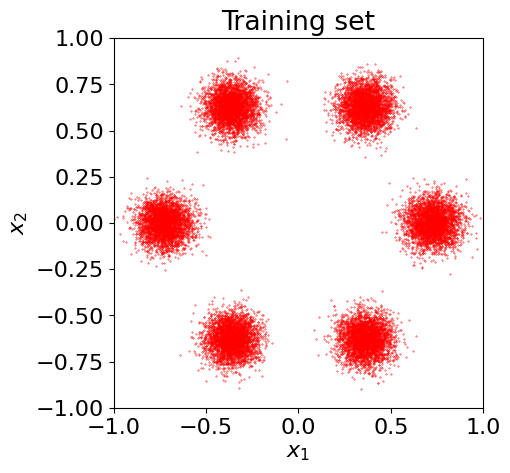

In [39]:
plt.scatter(X_train[:, 0], X_train[:, 1], s=0.1, color='red',label='Train')
plt.title("Training set")
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')

In [40]:
batches_in_epoch = len(X_train) // args['batch_size']

In [41]:
batches_in_epoch

40

In [42]:
import itertools
data_gen = itertools.cycle(jnp.array(jnp.array_split(jax.random.permutation(jax.random.PRNGKey(42),X_train), batches_in_epoch )))

# Gen & Discri simple architectures

In [43]:
import functools
from typing import Any, Callable, Sequence, Optional
import jax
from jax import lax, random, numpy as jnp
import flax
from flax import linen as nn


from jax.nn.initializers import normal as normal_init
from flax.training import train_state


In [44]:
TrainState = train_state.TrainState

class Generator(nn.Module):
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, z: jnp.ndarray, train: bool = True):

    x = z.reshape((args['batch_size_p'], args['z_dim']))
    x = nn.Dense(512,name=f'Gen_layers_1', dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(512,name=f'Gen_layers_2', dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(512,name=f'Gen_layers_3', dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(args['x_dim'],name=f'Gen_layers_4', dtype=self.dtype)(x)
    return x


class Discriminator(nn.Module):
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, x: jnp.ndarray, train: bool = True):

    x = nn.Dense(512,name=f'Dis_layers_1',dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(512,name=f'Dis_layers_2',dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(512,name=f'Dis_layers_3',dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(1,name=f'Dis_layers_4',dtype=self.dtype)(x)
    return x.reshape((args['batch_size_p'], -1))

# GAN Loss

In [45]:
import optax

In [46]:
@partial(jax.pmap, axis_name='num_devices')
def generator_step(generator_state: TrainState,
                   discriminator_state: TrainState,
                   key: PRNGKey):
  r"""The generator is updated by generating data and letting the discriminator
  critique it. It's loss goes down if the discriminator wrongly predicts it to
  to be real data."""
  input_noise = jax.random.uniform(key, (args['batch_size_p'], args['z_dim']), minval=-1,maxval=1) # normal

  def loss_fn(params):
    generated_data = generator_state.apply_fn(
        {'params': params},
        input_noise)

    logits  = discriminator_state.apply_fn(
            {'params': discriminator_state.params},
             generated_data)

    loss = optax.sigmoid_binary_cross_entropy(
                    logits, args['true_label']).mean()

    return loss

  # Generate data with the Generator, critique it with the Discriminator.
  grad_fn = jax.value_and_grad(loss_fn)#, has_aux=True)
  loss,  grads = grad_fn(generator_state.params)

  # Average across the devices.
  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Update the Generator through gradient descent.
  new_generator_state = generator_state.apply_gradients(
      grads=grads)

  return new_generator_state, loss


@partial(jax.pmap, axis_name='num_devices')
def discriminator_step(generator_state: TrainState,
                       discriminator_state: TrainState,
                       real_data: jnp.ndarray,
                       key: PRNGKey):
  r"""The discriminator is updated by critiquing both real and generated data,
  It's loss goes down as it predicts correctly if images are real or generated.
  """
  input_noise = jax.random.uniform(key, (args['batch_size_p'], args['z_dim']), minval=-1,maxval=1) # normal

  generated_data = generator_state.apply_fn(
        {'params': generator_state.params},
         input_noise)

  def loss_fn(params):
    logits_real = discriminator_state.apply_fn(
        {'params': params},
        real_data)

    logits_generated = discriminator_state.apply_fn(
        {'params': params},
        generated_data)

    real_loss = optax.sigmoid_binary_cross_entropy(
        logits_real, args['true_label']).mean()
    generated_loss = optax.sigmoid_binary_cross_entropy(
        logits_generated, args['false_label']).mean()

    loss = (real_loss + generated_loss) / 2

    return loss

  # Critique real and generated data with the Discriminator.
  grad_fn = jax.value_and_grad(loss_fn)#, has_aux=True)
  loss, grads = grad_fn(discriminator_state.params)

  # Average cross the devices.
  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Update the discriminator through gradient descent.
  new_discriminator_state = discriminator_state.apply_gradients(
      grads=grads)

  return new_discriminator_state, loss

# Training
restart from here if you want to change training parameters

In [47]:
import shutil
import os
dirpath = os.path.join("./","results", "test2D")
print(dirpath)
os.makedirs(dirpath,exist_ok=True)

./results/test2D


In [48]:
import glob
files = glob.glob(f'{dirpath}/GAN*')
for f in files:
    os.remove(f)

In [49]:
@partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def create_state(rng, model_cls, input_shape):
  r"""Create the training state given a model class. """
  model = model_cls()

  # tx = optax.adam(0.0002, b1=0.5, b2=0.999)
  tx = optax.adam(5e-5)
  variables = model.init(rng, jnp.ones(input_shape))

  state = TrainState.create(apply_fn=model.apply, tx=tx,
      params=variables['params'])

  return state


@jax.pmap
def sample_from_generator(generator_state, input_noise):
  """Sample from the generator in evaluation mode."""
  generated_data = generator_state.apply_fn(
      {'params': generator_state.params},
      input_noise, train=False)
  return generated_data

In [50]:
from flax.training.common_utils import shard, shard_prng_key


key = jax.random.PRNGKey(seed=args['seed'])
key_generator, key_discriminator, key = jax.random.split(key, 3)
key_generator = shard_prng_key(key_generator)
key_discriminator = shard_prng_key(key_discriminator)

discriminator_state = create_state(key_discriminator, Discriminator,
    (args['batch_size_p'], *next(data_gen).shape[1:]))

generator_state = create_state(key_generator, Generator,
    (args['batch_size_p'], args['z_dim']))

generator_input = jax.random.uniform(key, (args['batch_size'], args['z_dim']), minval=-1,maxval=1) # normal
generator_input = shard(generator_input)

In [51]:
key, key_generator, key_discriminator = jax.random.split(key, 3)
key_generator = shard_prng_key(key_generator)
key_discriminator = shard_prng_key(key_discriminator)

# Shard the data to possible devices.
batch_data = shard(next(data_gen))

# Take a step with the generator.
generator_state, generator_loss = generator_step(generator_state,
          discriminator_state, key_generator)

In [56]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

info_gen_losses=[]
info_dis_losses=[]
#args['epochs'] = 1000
pbar = tqdm(range(1, args['epochs'] + 1))
for epoch in pbar:
  for batch in range(batches_in_epoch):

      # Generate RNG keys for generator and discriminator.
      key, key_generator, key_discriminator = jax.random.split(key, 3)
      key_generator = shard_prng_key(key_generator)
      key_discriminator = shard_prng_key(key_discriminator)

      # Shard the data to possible devices.
      batch_data = shard(next(data_gen))

      # Take a step with the generator.
      generator_state, generator_loss = generator_step(generator_state,
          discriminator_state, key_generator)

      # Take a step with the discriminator.
      discriminator_state, discriminator_loss = discriminator_step(
          generator_state, discriminator_state, batch_data, key_discriminator)

      #progress_bar_train.update(1)

  metrics = jax.device_get([generator_loss[0], discriminator_loss[1]])

  info_gen_losses.append(metrics[0])
  info_dis_losses.append(metrics[1])

#    message = f"Epoch: {epoch: <2} | "
#    message += f"Generator loss: {metrics[0]:.3f} | "
#    message += f"Discriminator loss: {metrics[1]:.3f}"
#    progress_bar_train.write(message)
  pbar.set_description(f"Epoch {epoch}")
  pbar.set_postfix(loss=metrics)


  # Sample from the generator using the fixed input. We need to
  # reshape if we are working on multiple devices.
  sample = sample_from_generator(generator_state, generator_input)
  sample = sample.reshape((-1,args['x_dim']))

  # Next, plot the static samples, save the fig to disk.
  if epoch % (args['epochs']//10) == 0:
    np.save(f"./results/test2D/GAN_epoch_{epoch}.npy",sample)

  0%|          | 0/1000 [00:00<?, ?it/s]

# Plots

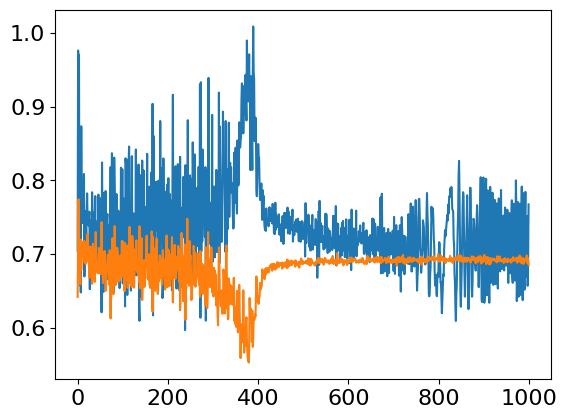

In [57]:
info_gen_losses = np.array(info_gen_losses)
info_dis_losses = np.array(info_dis_losses)
plt.plot(info_gen_losses)
plt.plot(info_dis_losses)

In [58]:
from pathlib import Path

In [59]:
files = glob.glob(f'{dirpath}/GAN*')
files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
n_plot=len(files)

In [60]:
files

['./results/test2D/GAN_epoch_100.npy',
 './results/test2D/GAN_epoch_200.npy',
 './results/test2D/GAN_epoch_300.npy',
 './results/test2D/GAN_epoch_400.npy',
 './results/test2D/GAN_epoch_500.npy',
 './results/test2D/GAN_epoch_600.npy',
 './results/test2D/GAN_epoch_700.npy',
 './results/test2D/GAN_epoch_800.npy',
 './results/test2D/GAN_epoch_900.npy',
 './results/test2D/GAN_epoch_1000.npy']

In [61]:
# find the "best" plot grid
import numbers
from math import sqrt

def get_dimensions(n):
    tempSqrt = sqrt(n)
    divisors = []
    currentDiv = 1
    for currentDiv in range(n):
        if n % float(currentDiv + 1) == 0:
         divisors.append(currentDiv+1)
    #print divisors this is to ensure that we're choosing well
    hIndex = min(range(len(divisors)), key=lambda i: abs(divisors[i]-sqrt(n)))

    if divisors[hIndex]*divisors[hIndex] == n:
        return divisors[hIndex], divisors[hIndex]
    else:
        wIndex = hIndex + 1
        return divisors[hIndex], divisors[wIndex]

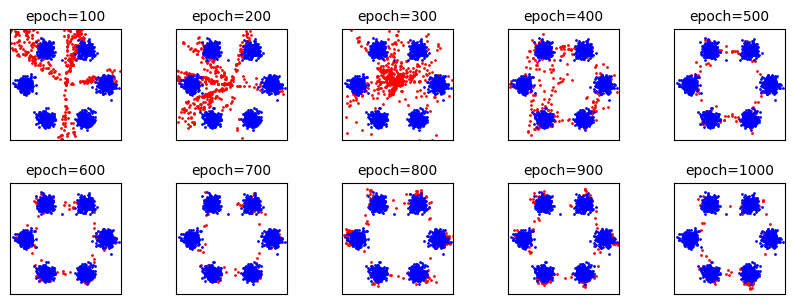

In [62]:
import re
nrows,ncols = get_dimensions(n_plot)
fig, axs = plt.subplots(nrows,ncols, figsize=(ncols*2,nrows*2))
axs = axs.ravel()
for i,f in enumerate(files):
    fname=Path(f).stem
    epoch_i = re.findall(r'\d+',fname)[0]
    spls = np.load(f)
    axs[i].scatter(spls[:, 0], spls[:, 1], s=1, color='red',label='Gen spls',alpha=1)
    axs[i].scatter(X_train[:len(spls)*3,0], X_train[:len(spls)*3,1], s=1, color='blue',label='Train',alpha=1)
    axs[i].set_title(f"epoch={epoch_i}",fontsize=10)

for i in range(len(axs)):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_aspect('equal')
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0)


plt.show()

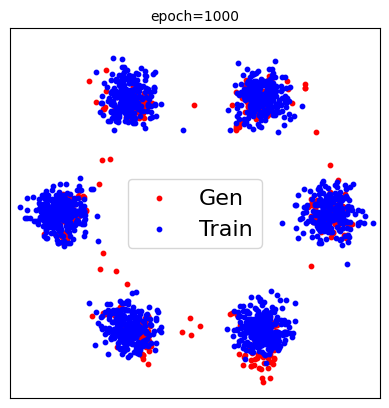

In [63]:
f_last=files[-1]
fname=Path(f_last).stem
epoch_i = re.findall(r'\d+',fname)[0]
spls = np.load(f_last)
plt.scatter(spls[:, 0], spls[:, 1], s=10, color='red',label='Gen',alpha=1)
plt.scatter(X_train[:len(spls)*3,0], X_train[:len(spls)*3,1], s=10, color='blue',label='Train',alpha=1)
plt.title(f'epoch={epoch_i}',fontsize=10)
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect('equal')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()

In [64]:
key,subkey = jax.random.split(jax.random.PRNGKey(100),2)
tst = jax.random.uniform(subkey, (args['batch_size'], args['x_dim']), minval=-1,maxval=1)

In [65]:
tst = shard(tst)

In [66]:
real_data = shard(next(data_gen))

In [67]:
@partial(jax.pmap, axis_name='num_devices')
def get_discri_loss(discriminator_state, x_spls, real_x):

    logits_real = discriminator_state.apply_fn(
        {'params': discriminator_state.params},
        real_x,  train=False, mutable=False)

    real_loss = optax.sigmoid_binary_cross_entropy(
        logits_real, args['true_label'])

    logits = discriminator_state.apply_fn(
      {'params': discriminator_state.params},
      x_spls, train=False, mutable=False)

    loss = optax.sigmoid_binary_cross_entropy(
        logits, args['false_label'])

    return (real_loss+loss)*0.5

In [68]:
loss = get_discri_loss(discriminator_state,tst,real_data)

In [69]:
tst=tst.reshape((-1,2))

In [70]:
loss = loss.reshape((-1,1))

In [71]:
from scipy.interpolate import Rbf

In [72]:
x = tst[:,1]
y = tst[:,0]
z = loss[:,0]

In [73]:
x_min, x_max = np.amin(x), np.amax(x)
y_min, y_max = np.amin(y), np.amax(y)

# Make a grid with spacing 0.002.
grid_x, grid_y = np.mgrid[x_min:x_max:0.002, y_min:y_max:0.002]


In [74]:
# Make an n-dimensional interpolator.
rbfi = Rbf(x, y, z, smooth=2)


In [75]:
# Predict on the regular grid.
di = rbfi(grid_x, grid_y)

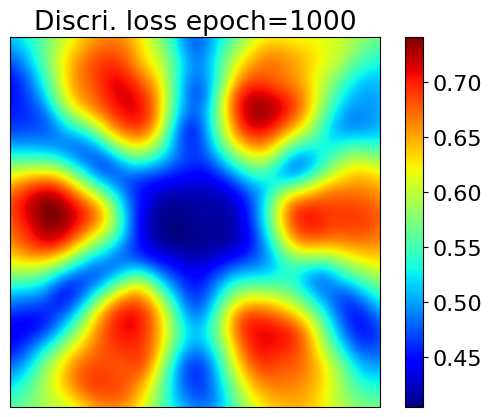

In [76]:
plt.imshow(di)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect('equal')
plt.title(f"Discri. loss epoch={epoch}"); # should last epoch